## Download Dataset

In [ ]:
# !wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

In [ ]:

# !apt-get install tar

In [ ]:
# !tar -xvf wiki_crop.tar

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# `Gender`

## Load Module

In [ ]:

import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

## Load Dataset

### Load metadata Mat file and convert into pandas Datafram

In [ ]:
mat = scipy.io.loadmat('wiki_crop/wiki.mat')

In [ ]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

In [ ]:

instances = mat['wiki'][0][0][0].shape[1]

df = pd.DataFrame(index = range(0,instances), columns = columns)

In [ ]:
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [ ]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


### Data processing

In [ ]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

#some records do not have a gender information
df = df[~df['gender'].isna()]

In [ ]:
df = df.drop(columns = ['dob','photo_taken','name','face_score','second_face_score','face_location'])

In [ ]:
df.head()

,full_path,gender
0,[17/10000217_1981-05-05_2009.jpg],1.0
2,[12/100012_1948-07-03_2008.jpg],1.0
4,[16/10002116_1971-05-31_2012.jpg],0.0
5,[02/10002702_1960-11-09_2012.jpg],0.0
6,[41/10003541_1937-09-27_1971.jpg],1.0


### Visualize data

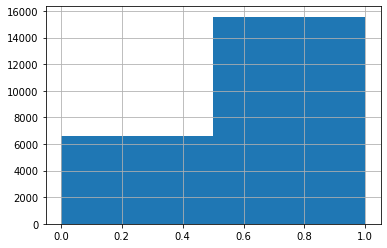

In [ ]:
histogram = df['gender'].hist(bins=df['gender'].nunique())

In [ ]:
df['gender'].value_counts().sort_index()
#0: woman, 1: man

0.0     6580
1.0    15575
Name: gender, dtype: int64

In [ ]:
classes = 2 #man woman
print("number of output classes: ",classes)

number of output classes:  2


### final df

In [ ]:
from sklearn.utils import shuffle


df = shuffle(df)

print(df.shape)
df.head()

(22155, 2)


,full_path,gender
31810,[61/4056361_1985-11-23_2014.jpg],1.0
55697,[07/4886507_1968-03-23_2009.jpg],1.0
12189,[85/7910885_1985-03-15_2012.jpg],1.0
15902,[21/1521421_1970-03-24_2011.jpg],1.0
9647,[61/15185261_1982-11-10_2009.jpg],1.0


### shrink data size due to load memory

In [ ]:
# sort data 
n_samples = 1000
df_sort = df.sort_values(by=['gender'])
df_sort.head()

,full_path,gender
12018,[03/39115103_1962-11-25_1998.jpg],0.0
47423,[85/2570785_1915-05-01_1961.jpg],0.0
42645,[54/37664254_1986-04-26_2015.jpg],0.0
30537,[01/38447901_1987-09-09_2012.jpg],0.0
21647,[78/34334078_1990-08-15_2013.jpg],0.0


In [ ]:
df_female = df_sort.iloc[:n_samples]
print(df_female.shape)
df_female.head()

(1000, 2)


,full_path,gender
12018,[03/39115103_1962-11-25_1998.jpg],0.0
47423,[85/2570785_1915-05-01_1961.jpg],0.0
42645,[54/37664254_1986-04-26_2015.jpg],0.0
30537,[01/38447901_1987-09-09_2012.jpg],0.0
21647,[78/34334078_1990-08-15_2013.jpg],0.0


In [ ]:
df_male = df_sort.iloc[-n_samples:]
print(df_male.shape)
df_male.head()

(1000, 2)


,full_path,gender
17703,[86/1828686_1971-09-21_2011.jpg],1.0
47588,[45/35729745_1941-01-04_1966.jpg],1.0
37110,[42/19529642_1989-10-20_2014.jpg],1.0
41329,[86/4563186_1938-12-03_2008.jpg],1.0
60413,[32/2697732_1952-08-23_2006.jpg],1.0


In [ ]:
from sklearn.utils import shuffle

df_shirnk = pd.concat([df_female, df_male])

df_shirnk = shuffle(df_shirnk)

print(df_shirnk.shape)
df_shirnk.head()

(2000, 2)


,full_path,gender
13392,[60/31286560_1980-12-28_2013.jpg],1.0
54905,[76/1788276_1979-06-08_2013.jpg],1.0
12,[82/10004882_1987-05-16_2010.jpg],1.0
24982,[98/104998_1949-07-24_1993.jpg],1.0
32401,[80/31590880_1989-06-23_2013.jpg],0.0


In [ ]:
df_shirnk.gender.value_counts()

0.0    1000
1.0    1000
Name: gender, dtype: int64

### Load image

In [ ]:
target_size = (224, 224)

def getImagePixels(image_path):
    img = image.load_img("wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x

In [ ]:
df_shirnk['pixels'] = df_shirnk['full_path'].apply(getImagePixels)

In [ ]:
df_shirnk.head()

,full_path,gender,pixels
13392,[60/31286560_1980-12-28_2013.jpg],1.0,"[130.0, 96.0, 87.0, 125.0, 91.0, 82.0, 115.0, ..."
54905,[76/1788276_1979-06-08_2013.jpg],1.0,"[20.0, 18.0, 23.0, 20.0, 18.0, 23.0, 20.0, 18...."
12,[82/10004882_1987-05-16_2010.jpg],1.0,"[187.0, 186.0, 192.0, 187.0, 186.0, 192.0, 187..."
24982,[98/104998_1949-07-24_1993.jpg],1.0,"[36.0, 27.0, 44.0, 35.0, 26.0, 43.0, 41.0, 32...."
32401,[80/31590880_1989-06-23_2013.jpg],0.0,"[196.0, 222.0, 219.0, 213.0, 231.0, 233.0, 213..."


In [ ]:
df = df_shirnk
df.head()

,full_path,gender,pixels
13392,[60/31286560_1980-12-28_2013.jpg],1.0,"[130.0, 96.0, 87.0, 125.0, 91.0, 82.0, 115.0, ..."
54905,[76/1788276_1979-06-08_2013.jpg],1.0,"[20.0, 18.0, 23.0, 20.0, 18.0, 23.0, 20.0, 18...."
12,[82/10004882_1987-05-16_2010.jpg],1.0,"[187.0, 186.0, 192.0, 187.0, 186.0, 192.0, 187..."
24982,[98/104998_1949-07-24_1993.jpg],1.0,"[36.0, 27.0, 44.0, 35.0, 26.0, 43.0, 41.0, 32...."
32401,[80/31590880_1989-06-23_2013.jpg],0.0,"[196.0, 222.0, 219.0, 213.0, 231.0, 233.0, 213..."


In [ ]:
target = df['gender'].values
target_classes = keras.utils.to_categorical(target, classes)

In [ ]:
#features = df['pixels'].values
features = []

for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [ ]:
features.shape

(2000, 224, 224, 3)

In [ ]:
features /= 255 #normalize in [0, 1]

### data split 

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30)

## Model

In [ ]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:

vgg_facenet_weight_path = 'put vgg model drive link here'
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights(vgg_facenet_weight_path)



In [ ]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

gender_model = Model(inputs=model.input, outputs=base_model_output)

In [ ]:

#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

### optimizer

In [ ]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

gender_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [ ]:
# gender_model.summary()

In [ ]:
checkpointer = ModelCheckpoint(
    filepath='classification_gender_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

### Train

In [ ]:
scores = []
enableFit = False

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = gender_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
        
        from keras.models import load_model
        gender_model = load_model("classification_gender_model.hdf5")
        
        gender_model.save_weights('gender_model_weights.h5')
        
else:
    #pre-trained weights for gender prediction: https://drive.google.com/file/d/1wUXRVlbsni2FN9-jkS_f4UTUrm1bRLyk/view?usp=sharing
    gender_model.load_weights("put gender model drive link here")

In [ ]:
# val_loss_change = []; loss_change = []
# for i in range(0, len(scores)):
#     val_loss_change.append(scores[i].history['val_loss'])
#     loss_change.append(scores[i].history['loss'])

# plt.plot(val_loss_change, label='val_loss')
# plt.plot(loss_change, label='train_loss')
# plt.legend(loc='upper right')
# plt.show()

### model evaluation

In [ ]:
#loss and accuracy on validation set
gender_model.evaluate(test_x, test_y, verbose=1)

19/19 [==============================] - 13s 241ms/step - loss: 0.0875 - accuracy: 0.9646


[0.08272451162338257, 0.9750000238418579]

In [ ]:
predictions = gender_model.predict(test_x)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

pred_list = []; actual_list = []

for i in predictions:
    pred_list.append(np.argmax(i))

for i in test_y: 
    actual_list.append(np.argmax(i))

confusion_matrix(actual_list, pred_list)

array([[279,  10],
       [  5, 306]])

### Test

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator



def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

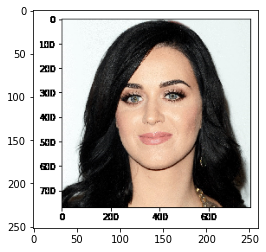

Gender is:  Woman


In [ ]:
picture = "/content/katt.png"

prediction = gender_model.predict(loadImage(picture))

img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()

gender = "Man" if np.argmax(prediction) == 1 else "Woman"

print("Gender is: ", gender)

## `Age`

### Load Module

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

## Dataset

### Load metadata mat file as pandas

In [ ]:
mat = scipy.io.loadmat('wiki_crop/wiki.mat')

In [ ]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]


instances = mat['wiki'][0][0][0].shape[1]

df = pd.DataFrame(index = range(0,instances), columns = columns)

In [ ]:
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [ ]:

df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


### Pre-processing

In [ ]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)
    
    return exact_date.year

In [ ]:
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [ ]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN,1981
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248,1925
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN,1948
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN,1930
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN,1971


In [ ]:

df['age'] = df['photo_taken'] - df['date_of_birth']

In [ ]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

In [ ]:
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])


In [ ]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]

#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [ ]:
df.head()

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


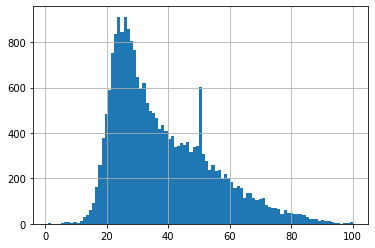

In [ ]:

histogram = df['age'].hist(bins=df['age'].nunique())

In [ ]:
classes = 101 #(0, 100])
print("number of output classes: ",classes)

number of output classes:  101


### Load Image

In [ ]:

target_size = (224, 224)

def getImagePixels(image_path):
    img = image.load_img("wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x

In [ ]:
df = df.iloc[:2000]

In [ ]:
df['pixels'] = df['full_path'].apply(getImagePixels)

In [ ]:
df.head()

,dob,photo_taken,full_path,gender,age,pixels
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60,"[92.0, 97.0, 91.0, 89.0, 94.0, 90.0, 91.0, 96...."
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41,"[61.0, 30.0, 10.0, 61.0, 30.0, 10.0, 61.0, 30...."
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52,"[97.0, 122.0, 178.0, 97.0, 122.0, 178.0, 97.0,..."
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34,"[190.0, 189.0, 194.0, 204.0, 203.0, 208.0, 203..."


In [ ]:
target = df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

In [ ]:

#features = df['pixels'].values
features = []

for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [ ]:
features /= 255 #normalize in [0, 1]
features.shape

(2000, 224, 224, 3)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes
                                        , test_size=0.30)#, random_state=42), stratify=target_classes)

## Model

In [ ]:

#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:

vgg_facenet_weight_path = 'put vgg model drive link here'
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights(vgg_facenet_weight_path)

In [ ]:

#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

In [ ]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [ ]:

sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [ ]:

checkpointer = ModelCheckpoint(
    filepath='classification_age_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

### Train

In [ ]:

scores = []
enableFit = False

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    age_model = load_model("classification_age_model.hdf5")
    
    age_model.save_weights('age_model_weights.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("put age model drive link here")

In [ ]:

# val_loss_change = []; loss_change = []
# for i in range(0, len(scores)):
#     val_loss_change.append(scores[i].history['val_loss'])
#     loss_change.append(scores[i].history['loss'])

# plt.plot(val_loss_change, label='val_loss')
# plt.plot(loss_change, label='train_loss')
# plt.legend(loc='upper right')
# plt.show()

### Model Evaluation

In [ ]:
#loss and accuracy on validation set
age_model.evaluate(test_x, test_y, verbose=1)

19/19 [==============================] - 4s 176ms/step - loss: 3.3129 - accuracy: 0.0582


[3.319784164428711, 0.08166666328907013]

In [ ]:

predictions = age_model.predict(test_x)

In [ ]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [ ]:

mae = 0
actual_mean = 0
for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    
    abs_error = abs(prediction - actual)
    actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  5.34
instances:  600


### Test

In [ ]:

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [ ]:
picture = "katt.png"
#picture = "brando.jpg"
#picture = "katy-3.jpg"

prediction = age_model.predict(loadImage(picture))

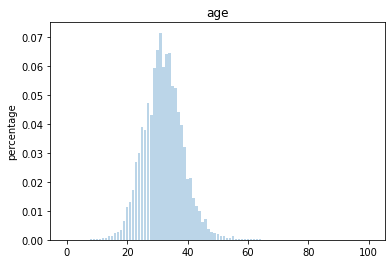

In [ ]:

y_pos = np.arange(101)
plt.bar(y_pos, prediction[0], align='center', alpha=0.3)
plt.ylabel('percentage')
plt.title('age')
plt.show()

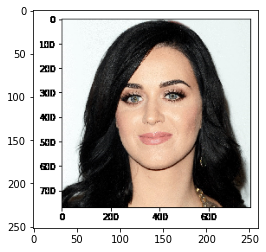

most dominant age class (not apparent age):  31
apparent age:  32


In [ ]:

img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))

apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
print("apparent age: ", int(apparent_age[0]))